### Compliation tracking
1. Preliminary model with $ 2 (14-12-2) $ layers, **regular** cross entropy loss function, no dropout <br>
&emsp;1.1 Features: origninal proposed features, no kyg features, min-max normalization for the features <br>
&emsp;1.2 Algorithm from kipf & welling with localized $ k = 1$
2. **Effective number based class-balanced weight** loss function, $2 (24-12-2)$ layers, no dropout <br>
&emsp;2.1 Same as 1.1 <br>
&emsp;2.2 Same as 1.2 <br>
&emsp;2.3 Hyperarameter of the loss function is set to 0.999999
3. **Effective number based class-balanced weight** loss function, $3 (24-16-8-2)$ layers, no dropout <br>
4. **Effective number based class-balanced weight** loss function, $4 (24-16-16-8-2)$ layers, no dropout ,br.
5. $K = 2, 3, 4$ instead of $1$

In [1]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### Testing Model, only using 2xzn for now

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from PCM import PCM
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.optim as optim
import numpy as np
import scipy.sparse as sp
import sklearn.metrics

In [5]:
AMINO_ACIDS = np.array(['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG'
               , 'SER','THR', 'VAL', 'TRP', 'TYR'])

In [6]:
"""
Layers of graph convolution
"""

class GClayer(Module):
    def __init__(self, nin, nout, bias = False):
        super(GClayer, self).__init__()
        self.in_features = nin
        self.out_features = nout
        self.weight = Parameter(torch.randn(nin, nout))
        
        if bias:
            self.bias = Parameter(torch.randn(out_features))
        else:
            self.register_parameter('bias', None)
        
    def forward(self, input, adj):
        temp = torch.mm(input, self.weight)
        output = torch.sparse.mm(adj, temp)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
    
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
    
    def __repr__(self):
        return self.__class__.__name__ + '(' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


In [7]:
"""
GCN model
"""

class GCN(nn.Module):
    def __init__(self, nfeat, nhid1, nhid2, nhid3, nclass, dropout):
        super(GCN, self).__init__()
        
        self.gc1 = GClayer(nfeat, nhid1)
        self.gc2 = GClayer(nhid1, nhid2)
        self.gc3 = GClayer(nhid2, nhid3)
        self.gc4 = GClayer(nhid3, nclass)
        self.dropout = dropout
        
    def forward(self, x, adj):
        x = F.leaky_relu(self.gc1(x, adj))
        #x = F.dropout(x, self.dropout, training=self.training)
        x = F.leaky_relu(self.gc2(x, adj))
        x = F.leaky_relu(self.gc3(x, adj))
        x = F.leaky_relu(self.gc4(x, adj))
        return F.softmax(x)

In [8]:
"""Get all different contact map"""
pcm = PCM('2BU1', '../datasets/Tongji/benchmark/pdb/2BU1.pdb')

cm1, res_list = pcm.getContactMap1()
cm2, _ = pcm.getContactMap2()
cm3, _ = pcm.getContactMap3()
cm4, _ = pcm.getContactMap4()

#different contact map's adjacency matrix
adj1 = sp.coo_matrix(cm1, dtype = 'int')
adj2 = sp.coo_matrix(cm2, dtype = 'int')
adj3 = sp.coo_matrix(cm3, dtype = 'int')
adj4 = sp.coo_matrix(cm4, dtype = 'int')

In [9]:
"""Laplacian Matrix with k = 1"""
def normalize(mx):
    row_sum = np.array(mx.sum(1), dtype = np.float32)
    r_inv = np.power(row_sum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0
    r_inv_mat = sp.diags(r_inv)
    #norm_lap = sp.eye(adj.shape[0]) - r_inv_mat.dot(adj)
    # this is wrong, the paper did not used laplacian graph
    norm_lap = r_inv_mat.dot(mx)
    return norm_lap

# print("Inverse degree matrix: {}\n Normalized Laplacian: {}".format(r_inv_mat, norm_lap))

"""Laplacian Matrix with k = 2, 3, 4"""
# k2_lap = sp.coo_matrix(2 * (norm_lap**2) - np.eye(norm_lap.shape[0]), dtype = 'float32')
# k3_lap = sp.coo_matrix(4 * (norm_lap**3) - 3 * norm_lap, dtype = 'float32')
# k4_lap = sp.coo_matrix(8 * (norm_lap**4) - 8 * (norm_lap ** 2), dtype = 'float32')

'Laplacian Matrix with k = 2, 3, 4'

In [10]:
norm_cm_1 = normalize(adj1)
norm_cm_2 = normalize(adj2)
norm_cm_3 = normalize(adj3)
norm_cm_4 = normalize(adj4)

In [11]:
"""def loadData():"""
f = np.genfromtxt('./trial_data/2BU1.txt', dtype = np.dtype(str))

features = np.array(f[:, 1:-1], dtype = np.float32)
labels = np.array(f[:, -1], dtype = np.int_)
reses = f[:, 0]

In [12]:
# min-max normalization for the features (bond to change a little)
for i in range(20, 24):
    features[:, i] = (features[:, i] - np.min(features[:, i])) / (np.max(features[:, i]) - np.min(features[:, i]))

In [13]:
"""
Converting sparse matrix to torch tensor
"""
def sparseToTensor(sp_mx):
    sp_mx = sp_mx.tocoo().astype(np.float32)
    #vertically stack row and column indices with non-zero value
    indices = torch.from_numpy(
        np.vstack((sp_mx.row, sp_mx.col)).astype(np.int_)) 
    values = torch.from_numpy(sp_mx.data)
    shape = torch.Size(sp_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [14]:
"""Turn everything into tensors (part of loadData())"""
temp = torch.LongTensor(range(adj1.shape[0]))
temp_perm = temp[torch.randperm(adj1.shape[0])]

train_idx_1 = temp_perm[:250]
val_idx_1 = temp_perm[250:300]
test_idx_1 = temp_perm[300:]

# print("Train index: {} \n Validation index: {} \n Test index: {}\n".format(train_idx_1, val_idx_1, test_idx_1))
# print("=========================================================================================================")

# norm_lap_1 = sparseToTensor(norm_lap)
# k2_lap_1 = sparseToTensor(k2_lap)
# k3_lap_1 = sparseToTensor(k3_lap)
# k4_lap_1 = sparseToTensor(k4_lap)
features_1 = torch.FloatTensor(features)
labels_1 = torch.LongTensor(labels)

# tensor of contact maps
cm1_lap_1 = sparseToTensor(norm_cm_1)
cm1_lap_2 = sparseToTensor(norm_cm_2)
cm1_lap_3 = sparseToTensor(norm_cm_3)
cm1_lap_4 = sparseToTensor(norm_cm_4)

# print("Labels: {}\n Features: {}\n Laplacia: {}".format(labels_1, features_1, norm_lap_1.to_dense())) #to_dense() shows the sparse matrix in regular dense format
#return adj, features, labels, train_idx, val_idx, test_idx

In [15]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [16]:
model = GCN(nfeat = features.shape[1],
            nhid1 = 16,
            nhid2 = 16,
            nhid3 = 8,
            nclass= 2,
            dropout = 0.5)
optimizer = optim.Adam(model.parameters(),
                       lr = 0.01, weight_decay = 5e-4)
print(model)

GCN(
  (gc1): GClayer(24 -> 16)
  (gc2): GClayer(16 -> 16)
  (gc3): GClayer(16 -> 8)
  (gc4): GClayer(8 -> 2)
)


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

if torch.cuda.is_available():
    model.to(device)
    features_1 = features_1.cuda() 
    norm_lap_1 = norm_lap_1.cuda()
    k2_lap_1 = k2_lap_1.cuda()
    labels_1 = labels_1.cuda()
    train_idx_1 = train_idx_1.cuda()
    val_idx_1 = val_idx_1.cuda()
    test_idx_1 = test_idx_1.cuda()

In [18]:
# train version #1, with flat loss function
def train_v1(epoch, _):
    t = time.time()
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    optimizer.zero_grad()
    output = model(features_1, norm_lap_1)
    
    loss_train = criterion(output[train_idx_1], labels_1[train_idx_1])
    acc_train = accuracy(output[train_idx_1], labels_1[train_idx_1])
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    loss_val = criterion(output[val_idx_1], labels_1[val_idx_1])
    acc_val = accuracy(output[val_idx_1], labels_1[val_idx_1])
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

In [19]:
classes_sizes = np.array([labels_1.size()[0] - labels_1.nonzero().size()[0], labels_1.nonzero().size()[0]])

In [20]:
# train version #2, with weighted loss function, beta is a hyper parameter
# have to try different betas
# betas = [0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 0.99999999]
def train_v2(epoch, beta):
    ######calculate the weights based on the paper with effective number######
    no_of_classes = 2
    effective_num = 1.0 - np.power(beta, classes_sizes)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes
    l = torch.tensor([0, 1])
    labels_one_hot = F.one_hot(l, no_of_classes).float()
    weights = torch.tensor(weights).float()
    if epoch == 0: print(weights)
    
    criterion = nn.CrossEntropyLoss(weight = weights)
    ###########################################################
    
    t = time.time()

    model.train()
    optimizer.zero_grad()
    output = model(features_1, cm1_lap_4)
    
    loss_train = criterion(output[train_idx_1], labels_1[train_idx_1])
    acc_train = accuracy(output[train_idx_1], labels_1[train_idx_1])
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    loss_val = criterion(output[val_idx_1], labels_1[val_idx_1])
    acc_val = accuracy(output[val_idx_1], labels_1[val_idx_1])
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

In [21]:
# train version #3, with localization set to k = 2
# four layers
def train_v3(epoch, beta):
    ######calculate the weights based on the paper with effective number######
    no_of_classes = 2
    effective_num = 1.0 - np.power(beta, classes_sizes)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes
    l = torch.tensor([0, 1])
    labels_one_hot = F.one_hot(l, no_of_classes).float()
    weights = torch.tensor(weights).float()
    if epoch == 0: print(weights)
    
    criterion = nn.CrossEntropyLoss(weight = weights)
    ###########################################################
    
    t = time.time()

    model.train()
    optimizer.zero_grad()
    output = model(features_1, k2_lap_1)
    
    loss_train = criterion(output[train_idx_1], labels_1[train_idx_1])
    acc_train = accuracy(output[train_idx_1], labels_1[train_idx_1])
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    loss_val = criterion(output[val_idx_1], labels_1[val_idx_1])
    acc_val = accuracy(output[val_idx_1], labels_1[val_idx_1])
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

In [22]:
list_loss_t, list_acc_t, list_loss_v, list_acc_v = [], [], [], []
for i in range(300):
    loss_train, acc_train, loss_val, acc_val = train_v2(i, 0.9999999)
    list_loss_t.append(loss_train)
    list_acc_t.append(acc_train)
    list_loss_v.append(loss_val)
    list_acc_v.append(acc_val)

tensor([0.1344, 1.8656])
Epoch: 0001 loss_train: 0.8100 acc_train: 0.0680 loss_val: 0.8434 acc_val: 0.0600 time: 0.0072s
Epoch: 0002 loss_train: 0.8100 acc_train: 0.0680 loss_val: 0.8434 acc_val: 0.0600 time: 0.0039s
Epoch: 0003 loss_train: 0.8100 acc_train: 0.0680 loss_val: 0.8434 acc_val: 0.0600 time: 0.0032s
Epoch: 0004 loss_train: 0.8100 acc_train: 0.0680 loss_val: 0.8433 acc_val: 0.0600 time: 0.0035s
Epoch: 0005 loss_train: 0.8099 acc_train: 0.0680 loss_val: 0.8431 acc_val: 0.0600 time: 0.0032s
Epoch: 0006 loss_train: 0.8096 acc_train: 0.0680 loss_val: 0.8426 acc_val: 0.0600 time: 0.0029s
Epoch: 0007 loss_train: 0.8090 acc_train: 0.0680 loss_val: 0.8406 acc_val: 0.0600 time: 0.0035s
Epoch: 0008 loss_train: 0.8061 acc_train: 0.0680 loss_val: 0.8340 acc_val: 0.0800 time: 0.0035s
Epoch: 0009 loss_train: 0.7996 acc_train: 0.0840 loss_val: 0.8252 acc_val: 0.0800 time: 0.0031s
Epoch: 0010 loss_train: 0.7900 acc_train: 0.0920 loss_val: 0.8142 acc_val: 0.1200 time: 0.0030s
Epoch: 0011 los

Epoch: 0088 loss_train: 0.4284 acc_train: 0.8920 loss_val: 0.4345 acc_val: 0.7800 time: 0.0031s
Epoch: 0089 loss_train: 0.4283 acc_train: 0.8920 loss_val: 0.4340 acc_val: 0.7800 time: 0.0032s
Epoch: 0090 loss_train: 0.4281 acc_train: 0.8920 loss_val: 0.4334 acc_val: 0.7800 time: 0.0031s
Epoch: 0091 loss_train: 0.4280 acc_train: 0.8920 loss_val: 0.4330 acc_val: 0.7800 time: 0.0030s
Epoch: 0092 loss_train: 0.4279 acc_train: 0.8920 loss_val: 0.4328 acc_val: 0.7800 time: 0.0029s
Epoch: 0093 loss_train: 0.4278 acc_train: 0.8920 loss_val: 0.4328 acc_val: 0.7800 time: 0.0029s
Epoch: 0094 loss_train: 0.4276 acc_train: 0.8920 loss_val: 0.4330 acc_val: 0.7800 time: 0.0032s
Epoch: 0095 loss_train: 0.4275 acc_train: 0.8920 loss_val: 0.4334 acc_val: 0.7800 time: 0.0031s
Epoch: 0096 loss_train: 0.4274 acc_train: 0.8920 loss_val: 0.4336 acc_val: 0.7800 time: 0.0039s
Epoch: 0097 loss_train: 0.4273 acc_train: 0.8920 loss_val: 0.4338 acc_val: 0.7800 time: 0.0035s
Epoch: 0098 loss_train: 0.4272 acc_train

Epoch: 0186 loss_train: 0.4141 acc_train: 0.9160 loss_val: 0.4853 acc_val: 0.8200 time: 0.0035s
Epoch: 0187 loss_train: 0.4138 acc_train: 0.9160 loss_val: 0.4915 acc_val: 0.8200 time: 0.0032s
Epoch: 0188 loss_train: 0.4136 acc_train: 0.9160 loss_val: 0.4990 acc_val: 0.8200 time: 0.0030s
Epoch: 0189 loss_train: 0.4134 acc_train: 0.9160 loss_val: 0.5048 acc_val: 0.8200 time: 0.0033s
Epoch: 0190 loss_train: 0.4131 acc_train: 0.9200 loss_val: 0.5093 acc_val: 0.8400 time: 0.0033s
Epoch: 0191 loss_train: 0.4128 acc_train: 0.9200 loss_val: 0.5148 acc_val: 0.8400 time: 0.0028s
Epoch: 0192 loss_train: 0.4125 acc_train: 0.9240 loss_val: 0.5191 acc_val: 0.8400 time: 0.0028s
Epoch: 0193 loss_train: 0.4122 acc_train: 0.9240 loss_val: 0.5222 acc_val: 0.8400 time: 0.0032s
Epoch: 0194 loss_train: 0.4118 acc_train: 0.9240 loss_val: 0.5242 acc_val: 0.8400 time: 0.0031s
Epoch: 0195 loss_train: 0.4115 acc_train: 0.9280 loss_val: 0.5259 acc_val: 0.8400 time: 0.0028s
Epoch: 0196 loss_train: 0.4112 acc_train

Epoch: 0284 loss_train: 0.4070 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0031s
Epoch: 0285 loss_train: 0.4070 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0029s
Epoch: 0286 loss_train: 0.4070 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0033s
Epoch: 0287 loss_train: 0.4070 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0030s
Epoch: 0288 loss_train: 0.4070 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0035s
Epoch: 0289 loss_train: 0.4070 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0032s
Epoch: 0290 loss_train: 0.4069 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0031s
Epoch: 0291 loss_train: 0.4069 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0033s
Epoch: 0292 loss_train: 0.4069 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0028s
Epoch: 0293 loss_train: 0.4069 acc_train: 0.9320 loss_val: 0.5293 acc_val: 0.8800 time: 0.0029s
Epoch: 0294 loss_train: 0.4069 acc_train

Text(0.5, 1.0, 'Validation Accuracy')

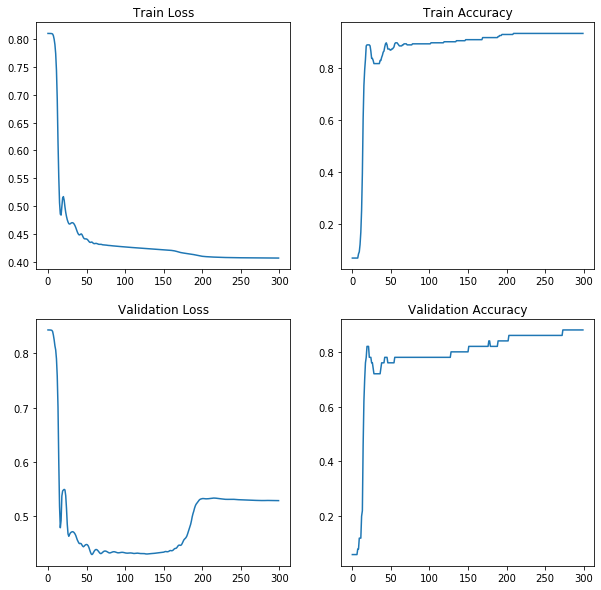

In [23]:
epochs = range(300)
f, axes = plt.subplots(2, 2, figsize = (10,10))
axes[0, 0].plot(epochs, list_loss_t)
axes[0, 0].set_title("Train Loss")
axes[0, 1].plot(epochs, list_acc_t)
axes[0, 1].set_title("Train Accuracy")
axes[1, 0].plot(epochs, list_loss_v)
axes[1, 0].set_title("Validation Loss")
axes[1, 1].plot(epochs, list_acc_v)
axes[1, 1].set_title("Validation Accuracy")

In [24]:
# def test():
model.eval()
output = model(features_1, cm1_lap_4)
loss_test = F.nll_loss(output[test_idx_1], labels_1[test_idx_1])
acc_test = accuracy(output[test_idx_1], labels_1[test_idx_1])
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test.item()))

Test set results: loss= -0.8735 accuracy= 0.8736


In [25]:
str(output.argmax(1).tolist())

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Counter({(0, 0): 332, (1, 0): 29, (1, 1): 21, (0, 1): 5})
TN 332
FN 5
FP 29
TP 21


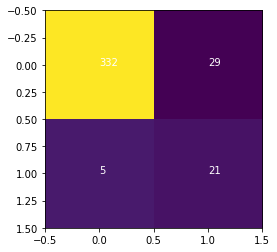

In [26]:
from collections import Counter
c = Counter(sorted(list(zip (output.argmax(1).tolist(),labels_1.tolist()))))

arr = np.zeros((2,2))
print(c)
for (x,y),count in c.items():
    arr[x,y] =count
    print({(0,0):"TN",(0,1):"FN",(1,0):"FP",(1,1):"TP"}[(x,y)],count)
    
plt.imshow(arr)
for (x,y),count in c.items():
    plt.text(x,y,count,c="w")


In [27]:
precision = c[(1,1)] / (c[(1,0)] + c[(1,1)])
print("Precision is {}".format(precision))

Precision is 0.42


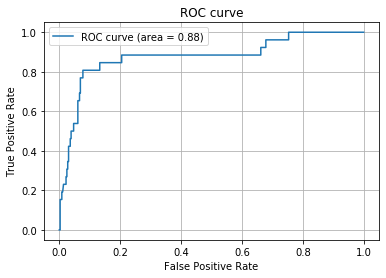

In [28]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels_1.cpu().tolist(), output[:,1].cpu().tolist())

auc = sklearn.metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
model_k1 = GCN(nfeat = features.shape[1],
            nhid1 = 16,
            nhid2 = 16,
            nhid3 = 8,
            nclass= 2,
            dropout = 0.5)
optimizer_k1 = optim.Adam(model_k1.parameters(),
                       lr = 0.01, weight_decay = 5e-4)

model_k2 = GCN(nfeat = features.shape[1],
            nhid1 = 16,
            nhid2 = 16,
            nhid3 = 8,
            nclass= 2,
            dropout = 0.5)
optimizer_k2 = optim.Adam(model_k2.parameters(),
                       lr = 0.01, weight_decay = 5e-4)


model_k3 = GCN(nfeat = features.shape[1],
            nhid1 = 16,
            nhid2 = 16,
            nhid3 = 8,
            nclass= 2,
            dropout = 0.5)
optimizer_k3 = optim.Adam(model_k3.parameters(),
                       lr = 0.01, weight_decay = 5e-4)

model_k4 = GCN(nfeat = features.shape[1],
            nhid1 = 16,
            nhid2 = 16,
            nhid3 = 8,
            nclass= 2,
            dropout = 0.5)
optimizer_k4 = optim.Adam(model_k4.parameters(),
                       lr = 0.01, weight_decay = 5e-4)

In [ ]:
def train_k1(epoch, beta):
    ######calculate the weights based on the paper with effective number######
    no_of_classes = 2
    effective_num = 1.0 - np.power(beta, classes_sizes)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes
    l = torch.tensor([0, 1])
    labels_one_hot = F.one_hot(l, no_of_classes).float()
    weights = torch.tensor(weights).float()
    if epoch == 0: print(weights)
    
    criterion = nn.CrossEntropyLoss(weight = weights)
    ###########################################################
    
    t = time.time()

    model_k1.train()
    optimizer_k1.zero_grad()
    output = model_k1(features_1, norm_lap_1)
    
    loss_train = criterion(output[train_idx_1], labels_1[train_idx_1])
    acc_train = accuracy(output[train_idx_1], labels_1[train_idx_1])
    optimizer_k1.zero_grad()
    loss_train.backward()
    optimizer_k1.step()

    loss_val = criterion(output[val_idx_1], labels_1[val_idx_1])
    acc_val = accuracy(output[val_idx_1], labels_1[val_idx_1])
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

def train_k2(epoch, beta):
    ######calculate the weights based on the paper with effective number######
    no_of_classes = 2
    effective_num = 1.0 - np.power(beta, classes_sizes)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes
    l = torch.tensor([0, 1])
    labels_one_hot = F.one_hot(l, no_of_classes).float()
    weights = torch.tensor(weights).float()
    if epoch == 0: print(weights)
    
    criterion = nn.CrossEntropyLoss(weight = weights)
    ###########################################################
    
    t = time.time()

    model_k2.train()
    optimizer_k2.zero_grad()
    output = model_k2(features_1, k2_lap_1)
    
    loss_train = criterion(output[train_idx_1], labels_1[train_idx_1])
    acc_train = accuracy(output[train_idx_1], labels_1[train_idx_1])
    optimizer_k2.zero_grad()
    loss_train.backward()
    optimizer_k2.step()

    loss_val = criterion(output[val_idx_1], labels_1[val_idx_1])
    acc_val = accuracy(output[val_idx_1], labels_1[val_idx_1])
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

def train_k3(epoch, beta):
    ######calculate the weights based on the paper with effective number######
    no_of_classes = 2
    effective_num = 1.0 - np.power(beta, classes_sizes)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes
    l = torch.tensor([0, 1])
    labels_one_hot = F.one_hot(l, no_of_classes).float()
    weights = torch.tensor(weights).float()
    if epoch == 0: print(weights)
    
    criterion = nn.CrossEntropyLoss(weight = weights)
    ###########################################################
    
    t = time.time()

    model_k3.train()
    optimizer_k3.zero_grad()
    output = model_k3(features_1, k3_lap_1)
    
    loss_train = criterion(output[train_idx_1], labels_1[train_idx_1])
    acc_train = accuracy(output[train_idx_1], labels_1[train_idx_1])
    optimizer_k3.zero_grad()
    loss_train.backward()
    optimizer_k3.step()

    loss_val = criterion(output[val_idx_1], labels_1[val_idx_1])
    acc_val = accuracy(output[val_idx_1], labels_1[val_idx_1])
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

def train_k4(epoch, beta):
    ######calculate the weights based on the paper with effective number######
    no_of_classes = 2
    effective_num = 1.0 - np.power(beta, classes_sizes)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes
    l = torch.tensor([0, 1])
    labels_one_hot = F.one_hot(l, no_of_classes).float()
    weights = torch.tensor(weights).float()
    if epoch == 0: print(weights)
    
    criterion = nn.CrossEntropyLoss(weight = weights)
    ###########################################################
    
    t = time.time()

    model_k4.train()
    optimizer_k4.zero_grad()
    output = model_k4(features_1, k4_lap_1)
    
    loss_train = criterion(output[train_idx_1], labels_1[train_idx_1])
    acc_train = accuracy(output[train_idx_1], labels_1[train_idx_1])
    optimizer_k4.zero_grad()
    loss_train.backward()
    optimizer_k4.step()

    loss_val = criterion(output[val_idx_1], labels_1[val_idx_1])
    acc_val = accuracy(output[val_idx_1], labels_1[val_idx_1])
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    return loss_train, acc_train, loss_val, acc_val

In [ ]:
list_loss_t_k1, list_acc_t_k1, list_loss_v_k1, list_acc_v_k1 = [], [], [], []
for i in range(300):
    loss_train_k1, acc_train_k1, loss_val_k1, acc_val_k1 = train_k1(i, 0.9999999)
    list_loss_t_k1.append(loss_train_k1)
    list_acc_t_k1.append(acc_train_k1)
    list_loss_v_k1.append(loss_val_k1)
    list_acc_v_k1.append(acc_val_k1)

list_loss_t_k2, list_acc_t_k2, list_loss_v_k2, list_acc_v_k2 = [], [], [], []
for i in range(300):
    loss_train_k2, acc_train_k2, loss_val_k2, acc_val_k2 = train_k2(i, 0.9999999)
    list_loss_t_k2.append(loss_train_k2)
    list_acc_t_k2.append(acc_train_k2)
    list_loss_v_k2.append(loss_val_k2)
    list_acc_v_k2.append(acc_val_k2)
    
list_loss_t_k3, list_acc_t_k3, list_loss_v_k3, list_acc_v_k3 = [], [], [], []
for i in range(300):
    loss_train_k3, acc_train_k3, loss_val_k3, acc_val_k3 = train_k3(i, 0.9999999)
    list_loss_t_k3.append(loss_train_k3)
    list_acc_t_k3.append(acc_train_k3)
    list_loss_v_k3.append(loss_val_k3)
    list_acc_v_k3.append(acc_val_k3)
    
list_loss_t_k4, list_acc_t_k4, list_loss_v_k4, list_acc_v_k4 = [], [], [], []
for i in range(300):
    loss_train_k4, acc_train_k4, loss_val_k4, acc_val_k4 = train_k4(i, 0.9999999)
    list_loss_t_k4.append(loss_train_k4)
    list_acc_t_k4.append(acc_train_k4)
    list_loss_v_k4.append(loss_val_k4)
    list_acc_v_k4.append(acc_val_k4)

In [ ]:
epochs = range(300)
f, axes = plt.subplots(2, 2, figsize = (10,10))
axes[0, 0].plot(epochs, list_loss_t_k1, 'r')
axes[0, 0].plot(epochs, list_loss_t_k2, 'g')
axes[0, 0].plot(epochs, list_loss_t_k3, 'b')
axes[0, 0].plot(epochs, list_loss_t_k4, 'y')
axes[0, 0].set_title("Train Loss")

axes[0, 1].plot(epochs, list_acc_t_k1, 'r')
axes[0, 1].plot(epochs, list_acc_t_k2, 'g')
axes[0, 1].plot(epochs, list_acc_t_k3, 'b')
axes[0, 1].plot(epochs, list_acc_t_k4, 'y')
axes[0, 1].set_title("Train Accuracy")

axes[1, 0].plot(epochs, list_loss_v_k1, 'r')
axes[1, 0].plot(epochs, list_loss_v_k2, 'g')
axes[1, 0].plot(epochs, list_loss_v_k3, 'b')
axes[1, 0].plot(epochs, list_loss_v_k4, 'y')
axes[1, 0].set_title("Validation Loss")

axes[1, 1].plot(epochs, list_acc_v_k1, 'r')
axes[1, 1].plot(epochs, list_acc_v_k2, 'g')
axes[1, 1].plot(epochs, list_acc_v_k3, 'b')
axes[1, 1].plot(epochs, list_acc_v_k4, 'y')
axes[1, 1].set_title("Validation Accuracy")

In [ ]:
model_k1.eval()
output_k1 = model_k1(features_1, norm_lap_1)
loss_test = F.nll_loss(output_k1[test_idx_1], labels_1[test_idx_1])
acc_test = accuracy(output_k1[test_idx_1], labels_1[test_idx_1])
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test.item()))

str(output_k1.argmax(1).tolist())

In [ ]:
model_k2.eval()
output_k2 = model_k2(features_1, k2_lap_1)
loss_test = F.nll_loss(output_k2[test_idx_1], labels_1[test_idx_1])
acc_test = accuracy(output_k2[test_idx_1], labels_1[test_idx_1])
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test.item()))

str(output_k2.argmax(1).tolist())

In [ ]:
model_k3.eval()
output_k3 = model_k3(features_1, k3_lap_1)
loss_test = F.nll_loss(output_k3[test_idx_1], labels_1[test_idx_1])
acc_test = accuracy(output_k3[test_idx_1], labels_1[test_idx_1])
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test.item()))

str(output_k3.argmax(1).tolist())

In [ ]:
model_k4.eval()
output_k4 = model_k4(features_1, k4_lap_1)
loss_test = F.nll_loss(output_k4[test_idx_1], labels_1[test_idx_1])
acc_test = accuracy(output_k4[test_idx_1], labels_1[test_idx_1])
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test.item()))

str(output_k4.argmax(1).tolist())

In [ ]:
fpr_k1, tpr_k1, thresholds_k1 = sklearn.metrics.roc_curve(labels_1[test_idx_1].cpu().tolist(), output_k1[test_idx_1][:,1].cpu().tolist())
auc_k1 = sklearn.metrics.auc(fpr_k1, tpr_k1)

fpr_k2, tpr_k2, thresholds_k2 = sklearn.metrics.roc_curve(labels_1[test_idx_1].cpu().tolist(), output_k2[test_idx_1][:,1].cpu().tolist())
auc_k2 = sklearn.metrics.auc(fpr_k2, tpr_k2)

fpr_k3, tpr_k3, thresholds_k3 = sklearn.metrics.roc_curve(labels_1[test_idx_1].cpu().tolist(), output_k3[test_idx_1][:,1].cpu().tolist())
auc_k3 = sklearn.metrics.auc(fpr_k3, tpr_k3)

fpr_k4, tpr_k4, thresholds_k4 = sklearn.metrics.roc_curve(labels_1[test_idx_1].cpu().tolist(), output_k4[test_idx_1][:,1].cpu().tolist())
auc_k4 = sklearn.metrics.auc(fpr_k4, tpr_k4)

plt.plot(fpr_k1, tpr_k1, label='K1 (area = %.2f)'%auc_k1)
plt.plot(fpr_k2, tpr_k2, label='K2 (area = %.2f)'%auc_k2)
plt.plot(fpr_k3, tpr_k3, label='K3 (area = %.2f)'%auc_k3)
plt.plot(fpr_k4, tpr_k4, label='K4 (area = %.2f)'%auc_k4)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
fpr_k1, tpr_k1, thresholds_k1 = sklearn.metrics.roc_curve(labels_1.cpu().tolist(), output_k1[:,1].cpu().tolist())
auc_k1 = sklearn.metrics.auc(fpr_k1, tpr_k1)

fpr_k2, tpr_k2, thresholds_k2 = sklearn.metrics.roc_curve(labels_1.cpu().tolist(), output_k2[:,1].cpu().tolist())
auc_k2 = sklearn.metrics.auc(fpr_k2, tpr_k2)

fpr_k3, tpr_k3, thresholds_k3 = sklearn.metrics.roc_curve(labels_1.cpu().tolist(), output_k3[:,1].cpu().tolist())
auc_k3 = sklearn.metrics.auc(fpr_k3, tpr_k3)

fpr_k4, tpr_k4, thresholds_k4 = sklearn.metrics.roc_curve(labels_1.cpu().tolist(), output_k4[:,1].cpu().tolist())
auc_k4 = sklearn.metrics.auc(fpr_k4, tpr_k4)

plt.plot(fpr_k1, tpr_k1, label='K1 (area = %.2f)'%auc_k1)
plt.plot(fpr_k2, tpr_k2, label='K2 (area = %.2f)'%auc_k2)
plt.plot(fpr_k3, tpr_k3, label='K3 (area = %.2f)'%auc_k3)
plt.plot(fpr_k4, tpr_k4, label='K4 (area = %.2f)'%auc_k4)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
temp = output_k4.tolist()
print(np.where(temp[:][0] == temp[:][1]))
print("No equal problilities for the two class in the given result k4")